

# Wind Turbine Power Prediction

## Goal
Predict power output of a wind turbine using environmental sensor data.

## Dataset
Source:https://drive.google.com/file/d/1Mh1CS2DJ4PuZAkUmn4Xwy96BBdAoZZK4/view?usp=sharing

Features: Wind Speed, Temperature, Pressure, etc.  
Target: Power Output

## Tools Used
- SQL
- Python (Pandas, NumPy)
- Scikit-learn (Regression Models)
- Matplotlib, Seaborn

## Models & Scores
| Model                   | RMSE  | MAE   | R² Score |
| ----------------------- | ----- | ----- | -------- |
| Linear Regression       | 1.969 | 1.416 | 0.387    |
| Random Forest Regressor | 1.242 | 0.923 | 0.756    |
| Neural Network (MLP)    | 2.592 | 1.993 | -0.063   |




## Visuals
- Histograms
- Scatter plots (Wind Speed vs Power Output)  
- Feature importance

# Step 1: Importing required libraries


In [ ]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Step 2: Load Dataset


In [ ]:
data = pd.read_csv('/content/train.csv')
print("Full dataset shape:", data.shape)

conn = sqlite3.connect('wind_turbine_data.db')
data.to_sql('turbine_data', conn, if_exists='replace', index=False)

data.info()

Full dataset shape: (7575, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7575 entries, 0 to 7574
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   timestamp                               7575 non-null   object 
 1   active_power_calculated_by_converter    7575 non-null   float64
 2   active_power_raw                        7575 non-null   float64
 3   ambient_temperature                     7575 non-null   float64
 4   generator_speed                         7575 non-null   float64
 5   generator_winding_temp_max              7575 non-null   float64
 6   grid_power10min_average                 7575 non-null   float64
 7   nc1_inside_temp                         7575 non-null   float64
 8   nacelle_temp                            7575 non-null   float64
 9   reactice_power_calculated_by_converter  7575 non-null   float64
 10  reactive_power               

In [ ]:
# SQL filtering for realistic feature selection

query = """
SELECT
    timestamp,
    turbine_id,
    ambient_temperature,
    generator_speed,
    nacelle_temp,
    wind_speed_raw,
    wind_speed_turbulence,
    reactive_power,
    active_power_raw,
    Target
FROM turbine_data
WHERE wind_speed_raw > 5
  AND ambient_temperature BETWEEN 5 AND 35
  AND nacelle_temp IS NOT NULL
LIMIT 10000"""

data = pd.read_sql_query(query, conn)

# Step 3: Sample Data for Speed


In [ ]:
data = data.sample(frac=0.2, random_state=42)  # 20% for faster training
print("Sampled dataset shape:", data.shape)
data.info()


Sampled dataset shape: (902, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 902 entries, 2028 to 4119
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              902 non-null    object 
 1   turbine_id             902 non-null    object 
 2   ambient_temperature    902 non-null    float64
 3   generator_speed        902 non-null    float64
 4   nacelle_temp           902 non-null    float64
 5   wind_speed_raw         902 non-null    float64
 6   wind_speed_turbulence  902 non-null    float64
 7   reactive_power         902 non-null    float64
 8   active_power_raw       902 non-null    float64
 9   Target                 902 non-null    float64
dtypes: float64(8), object(2)
memory usage: 77.5+ KB


# Step 4: Data Preprocessing and Feature Engineering



In [ ]:

# Convert timestamp to datetime and extract features
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day

# Drop original timestamp
data = data.drop('timestamp', axis=1)

# Encode turbine_id
le = LabelEncoder()
data['turbine_id'] = le.fit_transform(data['turbine_id'])

# Fill missing values with mean
data = data.fillna(data.mean())

# Define features and target
X = data.drop("Target", axis=1)
y = data["Target"]

In [ ]:

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for LR & NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5:Model Training


In [ ]:

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestRegressor(
    n_estimators=50,  # fewer trees
    max_depth=15,     # limit depth to reduce overfitting & time
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Neural Network (MLP)
mlp = MLPRegressor(
    hidden_layer_sizes=(32,16),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


# Step 6: Evaluation Metrics


In [ ]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE
    mae = mean_absolute_error(y_true, y_pred)          # MAE
    r2 = r2_score(y_true, y_pred)                      # R² score
    print(f"{name} → RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

# Evaluate all models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Neural Network (MLP)", y_test, y_pred_mlp)


Linear Regression → RMSE: 2.459, MAE: 1.712, R²: 0.236
Random Forest → RMSE: 1.976, MAE: 1.283, R²: 0.506
Neural Network (MLP) → RMSE: 4.266, MAE: 3.364, R²: -1.301


# Step 7: Visualizations


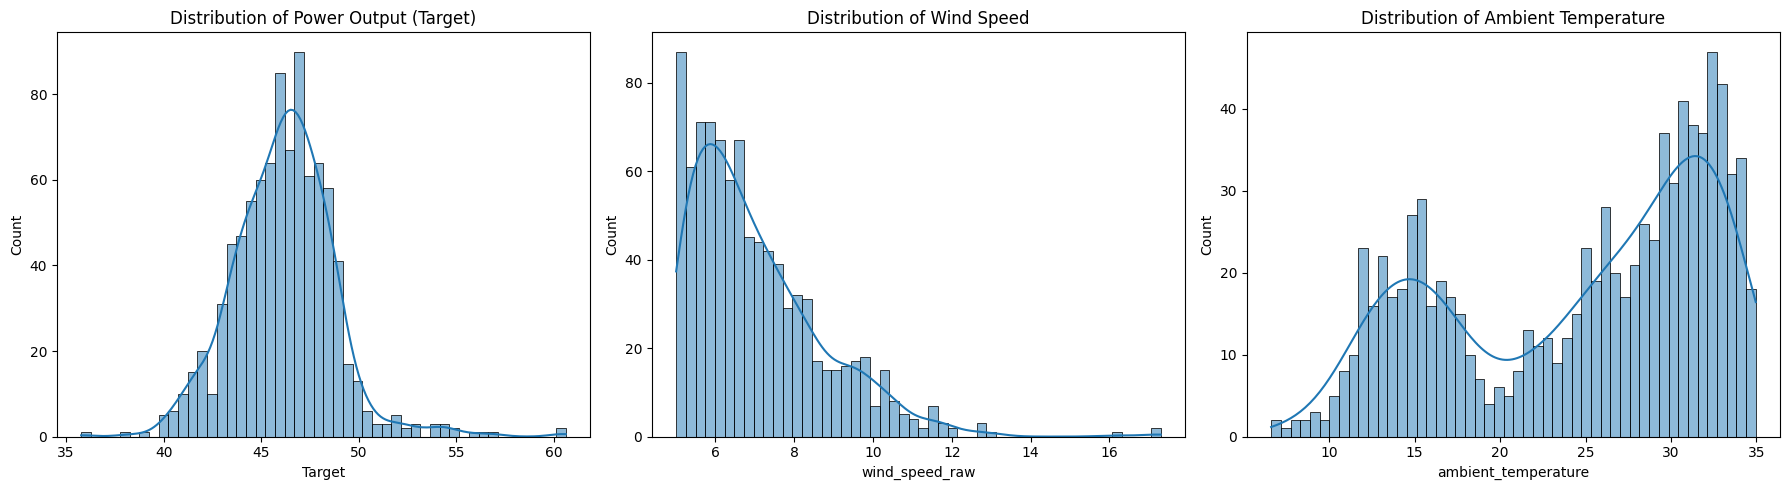

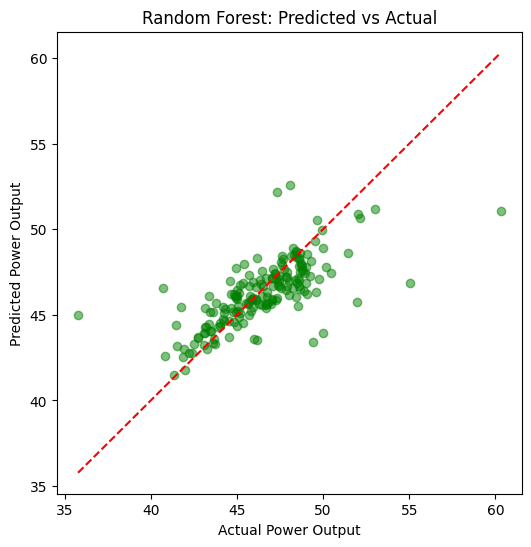

/tmp/ipython-input-3675278762.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="viridis")


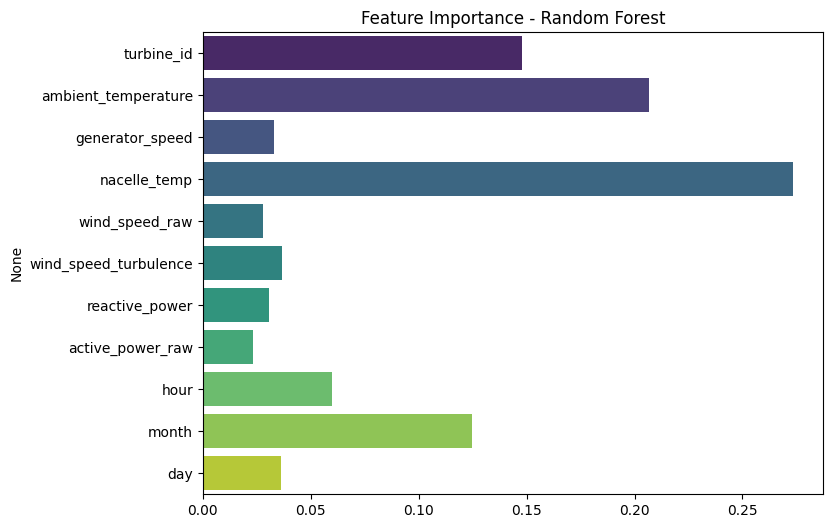

In [ ]:
# Histograms:
# Plot distributions of key features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data["Target"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Power Output (Target)")

sns.histplot(data["wind_speed_raw"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Wind Speed")

sns.histplot(data["ambient_temperature"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Distribution of Ambient Temperature")
plt.tight_layout()
plt.show()




# Predicted vs Actual (Random Forest)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual Power Output")
plt.ylabel("Predicted Power Output")
plt.title("Random Forest: Predicted vs Actual")
plt.show()

# Feature Importance (Random Forest)
importances = rf.feature_importances_
features = X.columns
plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.show()


# step-8: Conclusion

This tool can help energy companies optimize turbine efficiency, forecast output, and allocate grid resources.


* Wind speed is the most important feature  
* Business Use: Helps predict energy production & plan grid load

In [ ]:
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Example: Combine input and predicted values
output_df = X_test.copy()
output_df['Actual'] = y_test.values
output_df['Predicted'] = y_pred_mlp

# Save to CSV
output_df.to_csv('turbine_predictions.csv', index=False)


In [ ]:
from google.colab import files
files.download('turbine_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>